In [1]:
# Imports
from utils import calculate_nutripoints
from sklearn.cluster import KMeans, DBSCAN
from statsmodels.stats import diagnostic
import statsmodels.formula.api as smf
from scipy import stats
from scipy.stats import pearsonr
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import cross_val_predict, train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, auc, roc_curve, r2_score
from sklearn.feature_selection import RFE
import math
from IPython.display import display
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

%matplotlib inline
sns.set_theme()

In [2]:
# Data Imports

year_grocery = pd.read_csv("data/year_osward_grocery.csv")
display(year_grocery.head())
print(year_grocery.shape)

,area_id,weight,weight_perc2.5,weight_perc25,weight_perc50,weight_perc75,weight_perc97.5,weight_std,weight_ci95,volume,...,man_day,population,male,female,age_0_17,age_18_64,age_65+,avg_age,area_sq_km,people_per_sq_km
0,E05000026,449.535137,32.5,166.4,300.0,500.0,1500.0,771.349423,3.716832,125.960833,...,37315,14370.0,7469.0,6901.0,4211.0,9421.0,738.0,29.572999,1.26,11404.761905
1,E05000027,413.130263,32.5,150.0,300.0,500.0,1500.0,626.395178,5.164174,110.664114,...,14474,10845.0,5228.0,5617.0,3205.0,6608.0,1032.0,33.568004,1.36,7974.264706
2,E05000028,407.100472,32.5,160.0,300.0,500.0,1200.0,545.890959,2.710677,121.990710,...,32138,13856.0,6750.0,7106.0,4180.0,8537.0,1139.0,32.032693,1.29,10741.085271
3,E05000029,384.173858,30.0,150.0,250.0,454.0,1500.0,591.837557,4.968373,122.245578,...,16223,10850.0,5300.0,5550.0,3023.0,6251.0,1576.0,36.004793,3.38,3210.059172
4,E05000030,356.882607,30.0,140.0,250.0,450.0,1000.0,465.284180,3.880963,109.959688,...,17522,11348.0,5515.0,5833.0,2747.0,6961.0,1640.0,37.247444,3.45,3289.275362


(638, 202)


In [3]:
# year_grocery=year_grocery.sort_values(by='representativeness_norm', ascending=False, ignore_index=True)
year_grocery = year_grocery.nlargest(
    int(0.8*len(year_grocery)), 'representativeness_norm')

In [4]:
#nutripoints=['nutri_energy','nutri_sugar', 'nutri_saturate', 'nutri_sodium', 'nutri_fibre', 'nutri_protein', 'nutri_fruit_veg']
year_grocery["nutripoints"] = year_grocery.apply(calculate_nutripoints, axis=1)
year_grocery["nutripoints"].describe()

count    510.000000
mean       9.237255
std        1.469929
min        0.500000
25%        8.500000
50%        9.000000
75%       10.000000
max       14.500000
Name: nutripoints, dtype: float64

In [5]:
display(year_grocery.head())

,area_id,weight,weight_perc2.5,weight_perc25,weight_perc50,weight_perc75,weight_perc97.5,weight_std,weight_ci95,volume,...,population,male,female,age_0_17,age_18_64,age_65+,avg_age,area_sq_km,people_per_sq_km,nutripoints
570,E05011117,382.039628,40.0,175.0,300.0,500.0,1000.0,363.202381,0.465398,105.990925,...,11911.0,6099.0,5812.0,1558.0,9552.0,801.0,34.867937,1.35,8822.962963,8.5
565,E05011112,398.825948,40.0,180.0,320.0,500.0,1000.0,397.149657,0.492467,107.602664,...,16365.0,8103.0,8262.0,2997.0,12218.0,1150.0,33.235625,1.30,12588.461538,8.0
246,E05000336,397.066289,40.0,180.0,300.0,500.0,1000.0,414.783419,0.608474,122.609742,...,11959.0,5764.0,6195.0,2625.0,7194.0,2140.0,40.250941,3.32,3602.108434,10.0
438,E05000605,416.199096,40.5,182.0,325.0,500.0,1200.0,506.239533,0.700727,107.997869,...,13599.0,7196.0,6403.0,2630.0,9919.0,1050.0,34.684389,1.31,10380.916031,9.0
162,E05000252,374.792470,40.0,173.7,300.0,500.0,1000.0,354.119901,0.563867,99.371843,...,12013.0,5828.0,6185.0,1709.0,8813.0,1491.0,37.502289,0.89,13497.752809,8.5


In [6]:
NUTRIENTS = ['fibre', 'protein', 'carb', 'fat', 'salt']
weight = year_grocery[NUTRIENTS].copy()

In [27]:
weight["weight_total"]=weight[NUTRIENTS].sum(axis=1)
display(weight)

,fibre,protein,carb,fat,salt,weight_total
570,1.598593,5.692745,16.309391,8.715335,0.633354,32.949418
565,1.582639,5.599176,17.197310,8.724019,0.639881,33.743025
246,1.586666,5.358469,17.790212,8.762667,0.600154,34.098168
438,1.624408,5.503870,17.458121,9.395772,0.631499,34.613669
162,1.652122,5.535345,15.330560,8.949198,0.597672,32.064898
...,...,...,...,...,...,...
67,1.645169,5.273701,20.586839,9.160612,0.587352,37.253673
255,1.613219,5.167449,19.674053,9.373158,0.593232,36.421111
266,1.700966,5.151850,18.893397,9.588215,0.539841,35.874269
4,1.607947,5.307003,19.581403,9.381808,0.566784,36.444945


In [8]:
list_column = ["area_id", "energy_tot", "energy_fat", "energy_saturate", "energy_sugar", "energy_protein", "energy_carb",
               "energy_fibre", "energy_alcohol", "h_nutrients_calories", "nutripoints"]
year_grocery = year_grocery.loc[:,
                                year_grocery.columns.isin(list(list_column))]
display(year_grocery.head())

,area_id,energy_fat,energy_saturate,energy_sugar,energy_protein,energy_carb,energy_fibre,energy_alcohol,energy_tot,h_nutrients_calories,nutripoints
570,E05011117,78.438016,30.789383,34.635855,22.770981,65.237562,3.026622,1.892084,171.365266,1.608028,8.5
565,E05011112,78.516170,30.681996,36.415653,22.396706,68.789239,2.984949,1.558974,174.246039,1.589399,8.0
246,E05000336,78.864004,32.414378,38.719523,21.433875,71.160848,2.994211,1.741239,176.194176,1.582813,10.0
438,E05000605,84.561946,33.918637,36.141050,22.015479,69.832483,3.067818,1.697021,181.174746,1.575484,9.0
162,E05000252,80.542785,31.635739,33.648475,22.141379,61.322242,3.149138,1.689631,168.845175,1.598050,8.5


In [9]:
len(set(year_grocery["area_id"].values))

510

In [10]:
grocery_analysis = year_grocery.copy()
grocery_analysis=grocery_analysis.drop("area_id",axis=1)
display(grocery_analysis.head())
print(len(grocery_analysis.columns))

,energy_fat,energy_saturate,energy_sugar,energy_protein,energy_carb,energy_fibre,energy_alcohol,energy_tot,h_nutrients_calories,nutripoints
570,78.438016,30.789383,34.635855,22.770981,65.237562,3.026622,1.892084,171.365266,1.608028,8.5
565,78.516170,30.681996,36.415653,22.396706,68.789239,2.984949,1.558974,174.246039,1.589399,8.0
246,78.864004,32.414378,38.719523,21.433875,71.160848,2.994211,1.741239,176.194176,1.582813,10.0
438,84.561946,33.918637,36.141050,22.015479,69.832483,3.067818,1.697021,181.174746,1.575484,9.0
162,80.542785,31.635739,33.648475,22.141379,61.322242,3.149138,1.689631,168.845175,1.598050,8.5


10


Text(0.5, 0.98, 'histplot for each column')

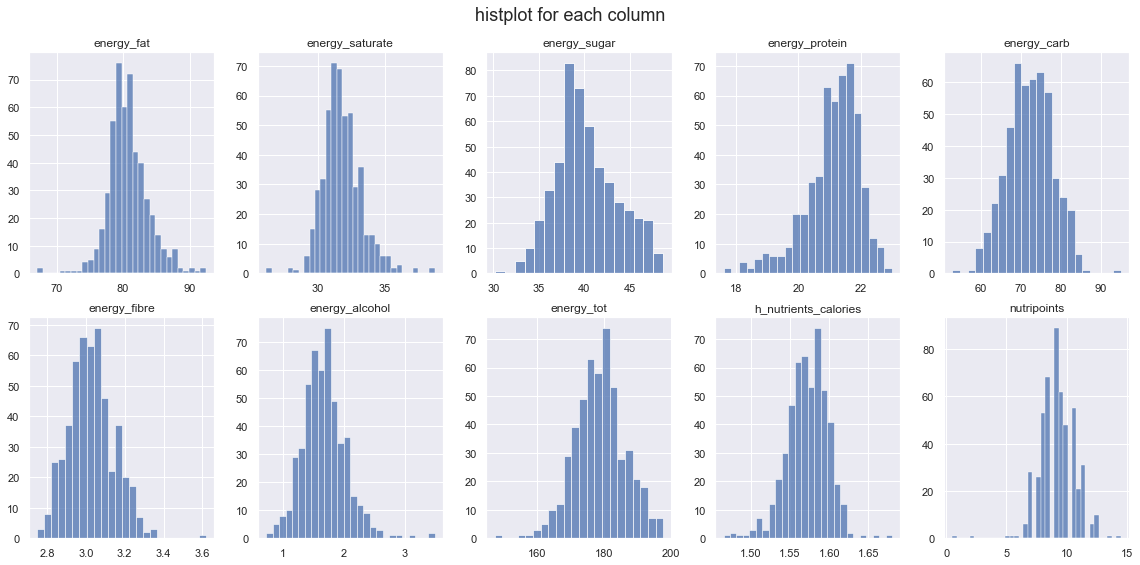

In [11]:
fig, ax = plt.subplots(2, 5, figsize=(16, 8), sharey=False)

for i in range(len(grocery_analysis.columns)):
    sbplt = ax[int(i/5), i % 5]

    sns.histplot(data=grocery_analysis.iloc[:, i], ax=sbplt)
    sbplt.set_xlabel('')
    sbplt.set_ylabel('')
    sbplt.set_title(grocery_analysis.columns[i], wrap=True)

fig.tight_layout()
fig.subplots_adjust(top=0.9)

fig.suptitle('histplot for each column', fontsize=18)

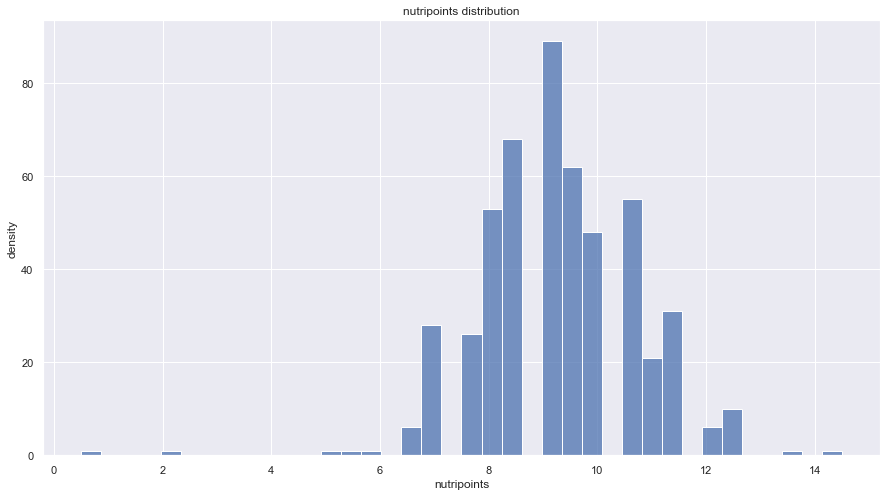

In [12]:
plt.figure(figsize=(15,8))

sns.histplot(data=grocery_analysis["nutripoints"])

plt.xlabel('nutripoints')
plt.ylabel('density')
plt.title('nutripoints distribution')
plt.show();

<AxesSubplot:>

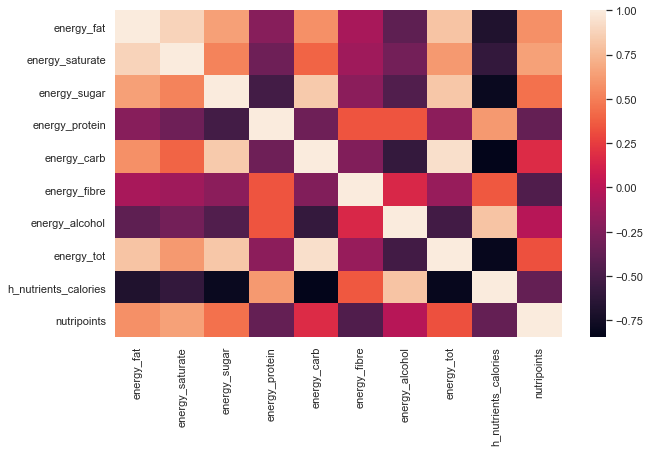

In [13]:
fig = plt.figure(figsize=(10, 6))
sns.heatmap(grocery_analysis.corr())

In [14]:
correlation = grocery_analysis.corr(method="spearman")
display(correlation)

,energy_fat,energy_saturate,energy_sugar,energy_protein,energy_carb,energy_fibre,energy_alcohol,energy_tot,h_nutrients_calories,nutripoints
energy_fat,1.000000,0.823451,0.608459,-0.165126,0.585389,-0.029370,-0.365324,0.785848,-0.624390,0.517034
energy_saturate,0.823451,1.000000,0.486850,-0.225230,0.378615,-0.047231,-0.221464,0.553098,-0.465406,0.615428
energy_sugar,0.608459,0.486850,1.000000,-0.539847,0.855277,-0.270308,-0.451466,0.812268,-0.808285,0.459735
energy_protein,-0.165126,-0.225230,-0.539847,1.000000,-0.346762,0.366865,0.325737,-0.212630,0.567731,-0.370445
energy_carb,0.585389,0.378615,0.855277,-0.346762,1.000000,-0.302417,-0.598661,0.943590,-0.875802,0.254035
energy_fibre,-0.029370,-0.047231,-0.270308,0.366865,-0.302417,1.000000,0.181677,-0.196165,0.380603,-0.452051
energy_alcohol,-0.365324,-0.221464,-0.451466,0.325737,-0.598661,0.181677,1.000000,-0.530316,0.804910,-0.000041
energy_tot,0.785848,0.553098,0.812268,-0.212630,0.943590,-0.196165,-0.530316,1.000000,-0.821297,0.334266
h_nutrients_calories,-0.624390,-0.465406,-0.808285,0.567731,-0.875802,0.380603,0.804910,-0.821297,1.000000,-0.342991
nutripoints,0.517034,0.615428,0.459735,-0.370445,0.254035,-0.452051,-0.000041,0.334266,-0.342991,1.000000


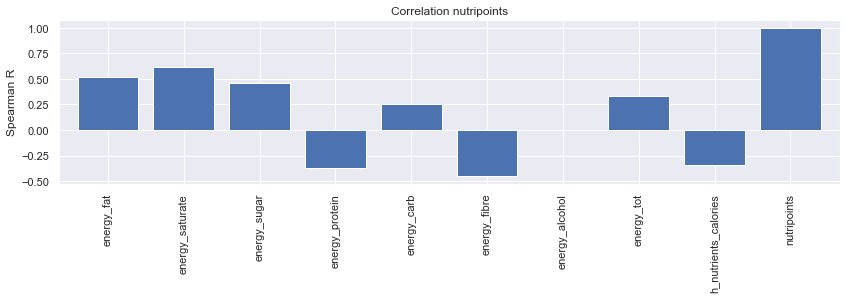

In [15]:
plt.figure(figsize=(14, 3))
correlation["nutripoints"].plot.bar(x=None, y=None, width=0.8, legend=None)
plt.ylabel("Spearman R")
plt.title("Correlation nutripoints")
plt.show()

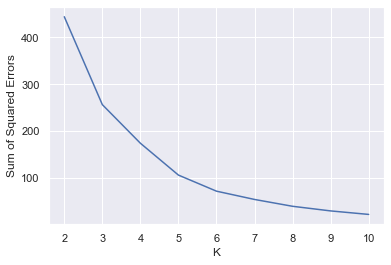

In [16]:
columns_kmeans = ['nutripoints']
grocery_kmeans = grocery_analysis[columns_kmeans].copy()


def plot_sse(X, start=2, end=11):
    sse = []
    for k in range(start, end):
        # Assign the labels to the clusters
        kmeans = KMeans(n_clusters=k, random_state=10).fit(X)
        sse.append({"k": k, "sse": kmeans.inertia_})
    sse = pd.DataFrame(sse)
    # Plot the data
    plt.plot(sse.k, sse.sse)
    plt.xlabel("K")
    plt.ylabel("Sum of Squared Errors")


plot_sse(grocery_kmeans)

<AxesSubplot:xlabel='nutripoints'>

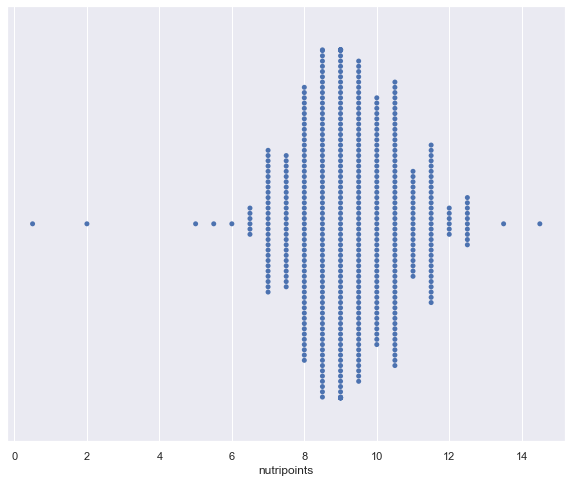

In [17]:
fig, axs = plt.subplots(1, 1, figsize=(10, 8), sharey=True, sharex=True)

# Cluster the data with the current number of clusters
kmean = KMeans(n_clusters=5, random_state=42).fit(grocery_kmeans)

# Plot the data by using the labels as color
#axs.scatter(wellbeing_grocery_kmeans, wellbeing_grocery_kmeans, c=kmean.labels_)
grocery_kmeans['label'] = kmean.labels_
sns.swarmplot(data=grocery_kmeans, x='nutripoints',ax=axs, hue=grocery_kmeans.label)
# Plot the centroids
# for c in kmean.cluster_centers_:
#axs.scatter(c[0], c[1], marker="+", color="red")

In [18]:
year_grocery["nutri_class"] = kmean.labels_
year_grocery.groupby("nutri_class")["nutripoints"].min()

nutri_class
0     9.5
1     5.0
2    11.0
3     0.5
4     8.5
Name: nutripoints, dtype: float64

In [19]:
display(year_grocery)

,area_id,energy_fat,energy_saturate,energy_sugar,energy_protein,energy_carb,energy_fibre,energy_alcohol,energy_tot,h_nutrients_calories,nutripoints,nutri_class
570,E05011117,78.438016,30.789383,34.635855,22.770981,65.237562,3.026622,1.892084,171.365266,1.608028,8.5,4
565,E05011112,78.516170,30.681996,36.415653,22.396706,68.789239,2.984949,1.558974,174.246039,1.589399,8.0,1
246,E05000336,78.864004,32.414378,38.719523,21.433875,71.160848,2.994211,1.741239,176.194176,1.582813,10.0,0
438,E05000605,84.561946,33.918637,36.141050,22.015479,69.832483,3.067818,1.697021,181.174746,1.575484,9.0,4
162,E05000252,80.542785,31.635739,33.648475,22.141379,61.322242,3.149138,1.689631,168.845175,1.598050,8.5,4
...,...,...,...,...,...,...,...,...,...,...,...,...
67,E05000114,82.445510,31.736518,47.351063,21.094804,82.347354,3.048458,1.509801,190.445927,1.548338,9.5,0
255,E05000345,84.358418,33.476880,45.331195,20.669797,78.696211,2.965964,1.698930,188.389319,1.550454,12.5,2
266,E05000356,86.293935,34.467013,42.264284,20.607400,75.573588,3.178303,1.352839,187.006066,1.545090,9.0,4
4,E05000030,84.436271,32.531970,45.331593,21.228013,78.325611,2.963643,1.182663,188.136201,1.540547,10.0,0


In [20]:
def addcolor(row_list):
    if row_list == 3:
        return "#038141"
    elif row_list == 1:
        return "#85BB2F"
    elif row_list == 4:
        return "#FECC02"
    elif row_list == 0:  
        return "#EE8300"
    elif row_list == 2:
        return "#E63F11"
    else: 
        return ""

      
year_grocery["color"] = year_grocery.apply(
    lambda row: addcolor(row["nutri_class"]), axis=1)
display(year_grocery)

,area_id,energy_fat,energy_saturate,energy_sugar,energy_protein,energy_carb,energy_fibre,energy_alcohol,energy_tot,h_nutrients_calories,nutripoints,nutri_class,color
570,E05011117,78.438016,30.789383,34.635855,22.770981,65.237562,3.026622,1.892084,171.365266,1.608028,8.5,4,#FECC02
565,E05011112,78.516170,30.681996,36.415653,22.396706,68.789239,2.984949,1.558974,174.246039,1.589399,8.0,1,#85BB2F
246,E05000336,78.864004,32.414378,38.719523,21.433875,71.160848,2.994211,1.741239,176.194176,1.582813,10.0,0,#EE8300
438,E05000605,84.561946,33.918637,36.141050,22.015479,69.832483,3.067818,1.697021,181.174746,1.575484,9.0,4,#FECC02
162,E05000252,80.542785,31.635739,33.648475,22.141379,61.322242,3.149138,1.689631,168.845175,1.598050,8.5,4,#FECC02
...,...,...,...,...,...,...,...,...,...,...,...,...,...
67,E05000114,82.445510,31.736518,47.351063,21.094804,82.347354,3.048458,1.509801,190.445927,1.548338,9.5,0,#EE8300
255,E05000345,84.358418,33.476880,45.331195,20.669797,78.696211,2.965964,1.698930,188.389319,1.550454,12.5,2,#E63F11
266,E05000356,86.293935,34.467013,42.264284,20.607400,75.573588,3.178303,1.352839,187.006066,1.545090,9.0,4,#FECC02
4,E05000030,84.436271,32.531970,45.331593,21.228013,78.325611,2.963643,1.182663,188.136201,1.540547,10.0,0,#EE8300


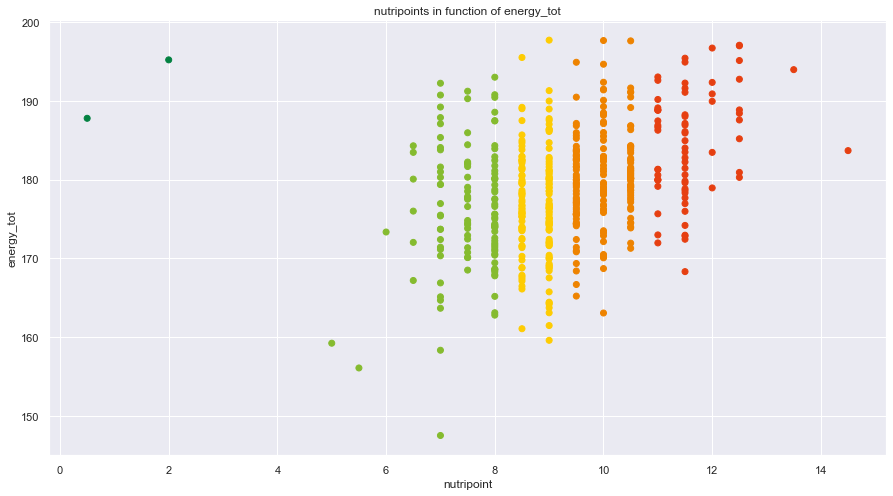

In [21]:
plt.figure(figsize=(15,8))

plt.scatter(year_grocery["nutripoints"],year_grocery["energy_tot"], c=year_grocery["color"])

plt.xlabel('nutripoint')
plt.ylabel('energy_tot')
plt.title('nutripoints in function of energy_tot')
plt.show();

Text(0.5, 0.98, 'histplot for each column')

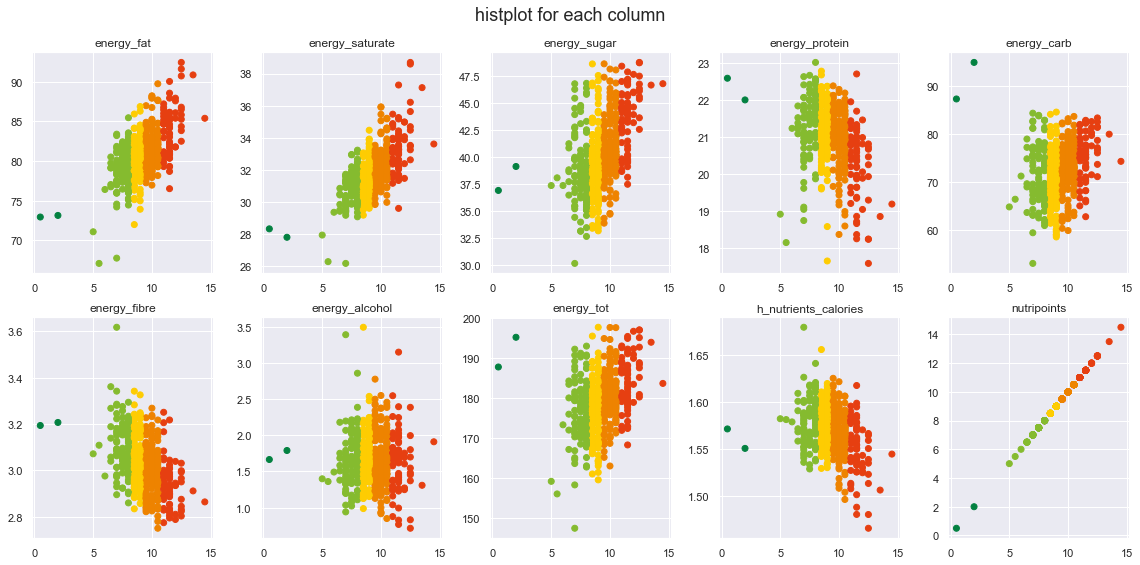

In [22]:
fig, ax = plt.subplots(2, 5, figsize=(16, 8), sharey=False)

for i in range(len(grocery_analysis.columns)):
    sbplt = ax[int(i/5), i % 5]
    sbplt.scatter(grocery_analysis["nutripoints"],grocery_analysis.iloc[:,i], c=year_grocery["color"])
    sbplt.set_xlabel('')
    sbplt.set_ylabel('')
    sbplt.set_title(grocery_analysis.columns[i], wrap=True)

fig.tight_layout()
fig.subplots_adjust(top=0.9)

fig.suptitle('histplot for each column', fontsize=18)

In [23]:
def nutri_labels_to_letter(row_list):
    if row_list == 3:
        return "A"
    elif row_list == 1:
        return "B"
    elif row_list == 4:
        return "C"
    elif row_list == 0:  
        return "D"
    elif row_list == 2:
        return "E"
    else: 
        return ""

      
year_grocery["nutrilabel"] = year_grocery.apply(
    lambda row: nutri_labels_to_letter(row["nutri_class"]), axis=1)
display(year_grocery)

,area_id,energy_fat,energy_saturate,energy_sugar,energy_protein,energy_carb,energy_fibre,energy_alcohol,energy_tot,h_nutrients_calories,nutripoints,nutri_class,color,nutrilabel
570,E05011117,78.438016,30.789383,34.635855,22.770981,65.237562,3.026622,1.892084,171.365266,1.608028,8.5,4,#FECC02,C
565,E05011112,78.516170,30.681996,36.415653,22.396706,68.789239,2.984949,1.558974,174.246039,1.589399,8.0,1,#85BB2F,B
246,E05000336,78.864004,32.414378,38.719523,21.433875,71.160848,2.994211,1.741239,176.194176,1.582813,10.0,0,#EE8300,D
438,E05000605,84.561946,33.918637,36.141050,22.015479,69.832483,3.067818,1.697021,181.174746,1.575484,9.0,4,#FECC02,C
162,E05000252,80.542785,31.635739,33.648475,22.141379,61.322242,3.149138,1.689631,168.845175,1.598050,8.5,4,#FECC02,C
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67,E05000114,82.445510,31.736518,47.351063,21.094804,82.347354,3.048458,1.509801,190.445927,1.548338,9.5,0,#EE8300,D
255,E05000345,84.358418,33.476880,45.331195,20.669797,78.696211,2.965964,1.698930,188.389319,1.550454,12.5,2,#E63F11,E
266,E05000356,86.293935,34.467013,42.264284,20.607400,75.573588,3.178303,1.352839,187.006066,1.545090,9.0,4,#FECC02,C
4,E05000030,84.436271,32.531970,45.331593,21.228013,78.325611,2.963643,1.182663,188.136201,1.540547,10.0,0,#EE8300,D


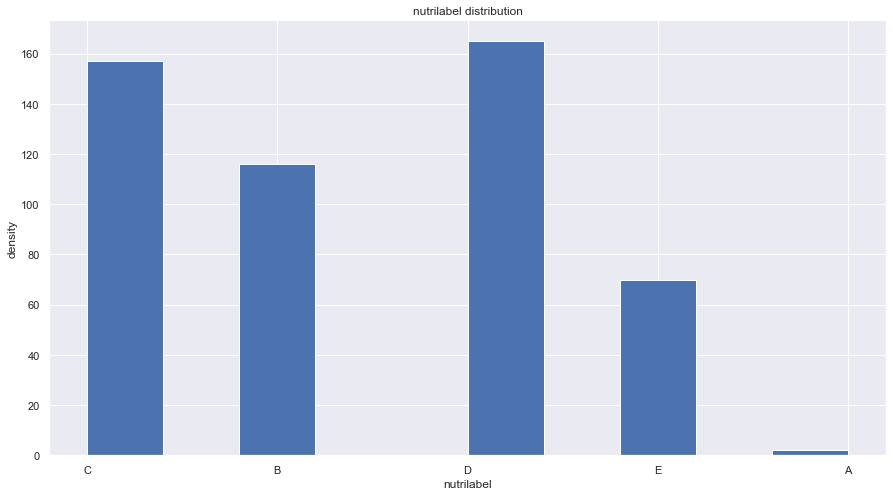

In [24]:
## REVOIR ##

plt.figure(figsize=(15,8))

#plt.bar(y_pos, height, color=['black', 'red', 'green', 'blue', 'cyan'])
#plt.xticks(y_pos, bars)
#plt.show()
height = [3, 12, 5, 18, 45]
bars = ('A', 'B', 'C', 'D', 'E')
y_pos = np.arange(len(bars))

clrs = [ "#038141","#85BB2F", "#FECC02", "#EE8300", "#E63F11"]

plt.hist(x=year_grocery["nutrilabel"])

#plt.xticks([0, 1, 2, 3, 4 ], ['A','B','C','D','E'])
#plt.xticks(y_pos, bars)
plt.xlabel('nutrilabel')
plt.ylabel('density')
plt.title('nutrilabel distribution')

plt.show();

In [25]:
def convert_kcal_to_joules(energy):
    return energy * 4.184


def convert_to_100g(nutrient_weight, total_weight):
    return nutrient_weight / total_weight * 100

In [30]:
def label_cal (row):
    if row['energy_tot']:
        energy_tot_kj = convert_kcal_to_joules(convert_to_100g(row['energy_tot'], weight.iloc[row.index,5]))
        
    if energy_tot_kj < 2123.6  :
        return 'low'
    elif energy_tot_kj < 2188.4 :
        return 'medium'
    else :
        return 'high'

def label_sugar(row):
    sugar = convert_to_100g(row['sugar'],weight.iloc[row.index,5])
    if sugar < 28.682:
        return 'low'
    elif sugar < 33.014 :
        return 'medium'
    else:
        return 'high'


# we add those new columns to the existing keto dataset:
grocery_analysis['calories'] = grocery_analysis.apply (lambda row: label_cal(row), axis=1)

grocery_analysis['sugar'] = grocery_anaylis.apply (lambda row: label_sugar(row), axis=1)


#Create dataframe

db=grocery_analysis.calories.value_counts().reset_index()
dd= grocery_analysis.sugar.value_counts().reset_index()

#Merge them on the 'index' column:
merged=db.merge(dd,on='index')
mergedstyle = merged.style.background_gradient(cmap='Greens')
mergedstyle

IndexError: .iloc requires numeric indexers, got ['energy_fat' 'energy_saturate' 'energy_sugar' 'energy_protein'
 'energy_carb' 'energy_fibre' 'energy_alcohol' 'energy_tot'
 'h_nutrients_calories' 'nutripoints']

In [ ]:
label1=db['index']
label2=dd['index']

fig = plt.figure(figsize=(15,10))
#2 rows 2 cols
#first row, first col
ax1 = plt.subplot2grid((1,1),(0,0))
plt.pie(db.calories,colors=("grey","r","orange"),labels=label1, autopct='%.2f',textprops={'fontsize': 14, 'weight':'bold'})
plt.title('calories',weight='bold', fontsize=18)
#first row sec col
ax1 = plt.subplot2grid((1,1), (0, 1))
plt.pie(dd.sugar,colors=("grey","r","orange"),labels=label2, autopct='%.2f',textprops={'fontsize': 14, 'weight':'bold'})
plt.title('fat',weight='bold', fontsize=18)

plt.show()